In [1]:
# Importer DataGenerator depuis le fichier data_generator.py
from DataGenerator import DataGenerator

2025-01-13 16:59:44.096324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 16:59:44.108776: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 16:59:44.112401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 16:59:44.122509: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'  # Configurer segmentation-models pour utiliser tf.keras

## Initialisation des paramètres

In [2]:
# Nombre de classes et poids pour l'entrainement
import pandas as pd

# Chargement du fichier class_weights.csv
class_weights_path = './data/class_weights.csv'
class_weights_df = pd.read_csv(class_weights_path)

# Calcul du nombre de classes (en-tête non inclus)
num_classes = len(class_weights_df)  # Nombre de lignes sans l'en-tête

# Création de la variable class_weights (colonne 'train_class_weights')
class_weights = class_weights_df['train_class_weights'].tolist()

In [63]:
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

{0: 0.0473117178270692,
 1: 0.0125407958691378,
 2: 0.0222351597861851,
 3: 0.2754032980979569,
 4: 0.0322249748165913,
 5: 0.137173815082615,
 6: 0.4069592459275001,
 7: 0.0661509925929445}

In [3]:
# Paramètres de taille des images
img_dim = 128  # Dimension des images (les images seront carrées)
image_size = (img_dim, img_dim)  # Taille des images
input_shape = (*image_size, 3)  # Forme d'entrée des images (hauteur, largeur, canaux)

In [4]:
# Initialisation des hyperparamètres par défaut
learning_rate = 1e-4
batch_size = 16

## Données

In [5]:
# Chargement des chemins des données
import numpy as np

# Chargement des chemins des images et masques pour validation
val_input_img_paths = np.load('data/val_input_img_paths.npy')
val_label_ids_img_paths = np.load('data/val_label_ids_img_paths.npy')

# Création du DataGenerator pour validation
from DataGenerator import DataGenerator  # Importer le DataGenerator depuis le script

val_gen = DataGenerator(
    image_paths=val_input_img_paths,
    mask_paths=val_label_ids_img_paths,
    image_size=image_size,  # Taille des images redimensionnées
    batch_size=batch_size,           # Taille des lots
    shuffle=True,           # Mélanger les données
    augmentation_ratio=0    # Pas d'augmentation pour la validation
)

# Tester le générateur
batch_images, batch_masks = next(iter(val_gen))
print(f"Taille du lot d'images : {batch_images.shape}")
print(f"Taille du lot de masques : {batch_masks.shape}")

Taille du lot d'images : (16, 128, 128, 3)
Taille du lot de masques : (16, 128, 128, 8)


In [6]:
# Définition des chemins pour les ensembles de données
train_input_img_paths = np.load('data/train_input_img_paths.npy')
train_label_ids_img_paths = np.load('data/train_label_ids_img_paths.npy')

test_input_img_paths = np.load('data/test_input_img_paths.npy')
test_label_ids_img_paths = np.load('data/test_label_ids_img_paths.npy')

# Générateur pour l'ensemble d'entraînement
train_gen = DataGenerator(
    image_paths=train_input_img_paths,
    mask_paths=train_label_ids_img_paths,
    image_size=image_size,  # Taille des images redimensionnées
    batch_size=batch_size,  # Taille des lots
    shuffle=True,           # Mélanger les données
    augmentation_ratio=0.3  # Augmentation de données pour l'entraînement
)

# Générateur pour l'ensemble de test
test_gen = DataGenerator(
    image_paths=test_input_img_paths,
    mask_paths=test_label_ids_img_paths,
    image_size=image_size,  # Taille des images redimensionnées
    batch_size=batch_size,  # Taille des lots
    shuffle=False,          # Pas besoin de mélanger les données de test
    augmentation_ratio=0    # Pas d'augmentation pour le test
)

# Tester chaque générateur
print("Train batch example:")
train_batch_images, train_batch_masks = next(iter(train_gen))
print(f"Taille du lot d'images (train) : {train_batch_images.shape}")
print(f"Taille du lot de masques (train) : {train_batch_masks.shape}")

print("\nTest batch example:")
test_batch_images, test_batch_masks = next(iter(test_gen))
print(f"Taille du lot d'images (test) : {test_batch_images.shape}")
print(f"Taille du lot de masques (test) : {test_batch_masks.shape}")


Train batch example:
Taille du lot d'images (train) : (16, 128, 128, 3)
Taille du lot de masques (train) : (16, 128, 128, 8)

Test batch example:
Taille du lot d'images (test) : (16, 128, 128, 3)
Taille du lot de masques (test) : (16, 128, 128, 8)


## Métrique

In [10]:
from segmentation_models.metrics import iou_score

# Fonction de métrique IoU avec conversion des masques en float32
def IOU_with_conversion(y_true, y_pred):
    # Convertir les masques et les prédictions en float32 pour éviter l'erreur de type
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Utilisation de la fonction iou_score de segmentation_models
    return iou_score(y_true, y_pred)


Segmentation Models: using `tf.keras` framework.


# Baseline: UNet mini

## Construction du modèle UNet mini

In [88]:
import tensorflow.keras as keras
import segmentation_models as sm
from tensorflow.keras.optimizers import Adam


# Chargement du modèle UNet avec un encodeur léger (VGG16)
model = sm.Unet(
    backbone_name='vgg16',         # Encodeur léger et simple
    encoder_weights='imagenet',   # Poids pré-entraînés sur ImageNet
    input_shape=input_shape,      # Dimensions d'entrée des images
    classes=num_classes,          # Nombre de classes
    activation='softmax'          # Activation pour la segmentation multi-classes
)

# Geler toutes les couches sauf la dernière
# for layer in model.layers:
    # Gel des couches de l'encodeur (tout sauf la dernière couche de sortie)
#    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.MaxPooling2D):
#        layer.trainable = False  # Geler les couches convolutives de l'encodeur

# Compiler le modèle
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',  # Perte pour multi-classes
    metrics=[IOU_with_conversion],    # Mesure d'IoU (Intersection over Union)
)

# Affichage du résumé du modèle
model.summary()



Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ input_layer_12[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 8, 8, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 23,753,288 (90.61 MB)

 Trainable params: 23,749,256 (90.60 MB)

 Non-trainable params: 4,032 (15.75 KB)

## Fonction d'entrainement

In [89]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, 
                                        ReduceLROnPlateau, Callback)

In [90]:
import numpy as np
import matplotlib.pyplot as plt

class MaskVisualizationCallback(tf.keras.callbacks.Callback):
    def __init__(self, sample_image, sample_mask, save_path="./training_masks"):
        self.sample_image = sample_image
        self.sample_mask = sample_mask
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        # Prédictions du modèle
        prediction = self.model.predict(np.expand_dims(self.sample_image, axis=0))[0]

        # Applatissement des masques et des prédictions
        mask_argmax = self.sample_mask.argmax(axis=-1)  # Masque réel aplati
        pred_argmax = prediction.argmax(axis=-1)  # Masque prédit aplati

        # Affichage de l'image, du masque réel et du masque prédit
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Image originale
        axes[0].imshow(self.sample_image, cmap='gray')
        axes[0].set_title("Image")
        
        # Masque réel aplati
        axes[1].imshow(mask_argmax, cmap='inferno')
        axes[1].set_title("Masque Réel")
        
        # Masque prédit aplati
        axes[2].imshow(pred_argmax, cmap='inferno')
        axes[2].set_title("Masque Prédit")
        
        plt.tight_layout()
        
        # Sauvegarde de l'image
        plt.savefig(f"{self.save_path}/mask_epoch_{epoch}.png")
        
        # Affichage de la figure dans le notebook
        plt.show()
        
        # Fermer la figure après affichage
        plt.close(fig)

In [91]:

# Assurez-vous que le dossier de sauvegarde existe
os.makedirs("./models", exist_ok=True)

# Exemple d'image et de masque pour la visualisation
sample_image, sample_mask = val_gen[0]  # Prenez la première image et son masque
sample_image = sample_image[0]  # Récupérer une image du lot
sample_mask = sample_mask[0]    # Récupérer un masque du lot


In [93]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        verbose=1
    ),
    ModelCheckpoint(
        filepath="./models/best_model.keras",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    MaskVisualizationCallback(
        sample_image=sample_image,
        sample_mask=sample_mask,
        save_path="./training_masks"
    )
]


Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - iou_with_conversion: 0.1261 - loss: 1.5359
Epoch 1: val_loss improved from inf to 0.94541, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


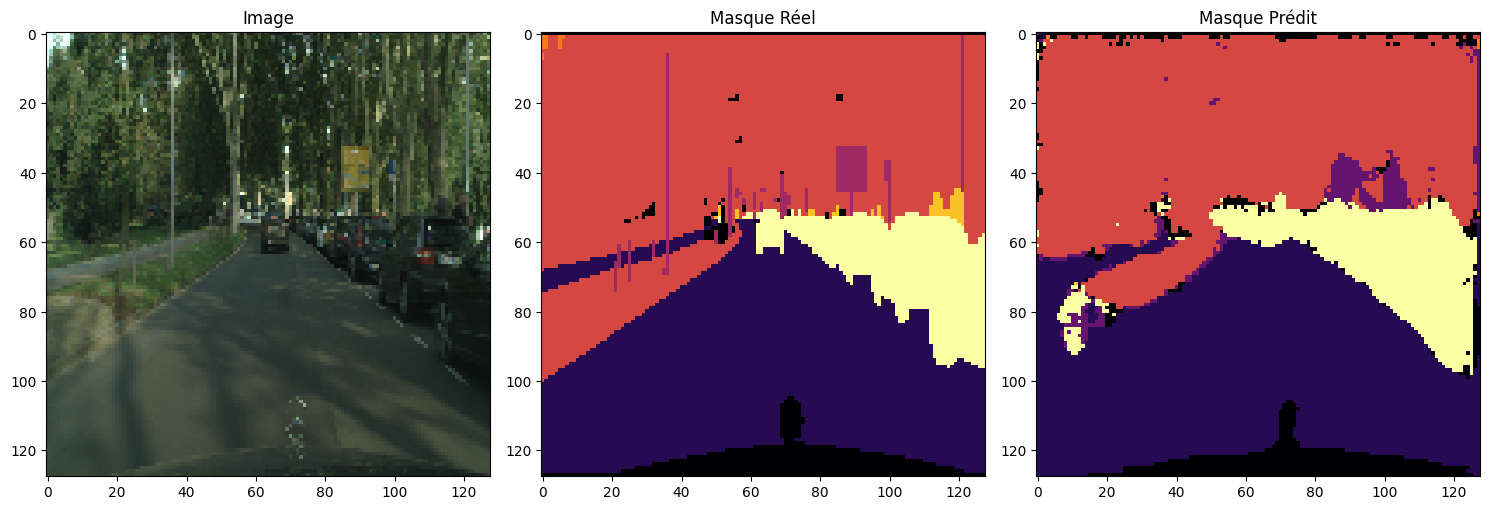

186/186 ━━━━━━━━━━━━━━━━━━━━ 191s 949ms/step - iou_with_conversion: 0.1265 - loss: 1.5340 - val_iou_with_conversion: 0.2221 - val_loss: 0.9454 - learning_rate: 1.0000e-04
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - iou_with_conversion: 0.3323 - loss: 0.6806
Epoch 2: val_loss improved from 0.94541 to 0.60462, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


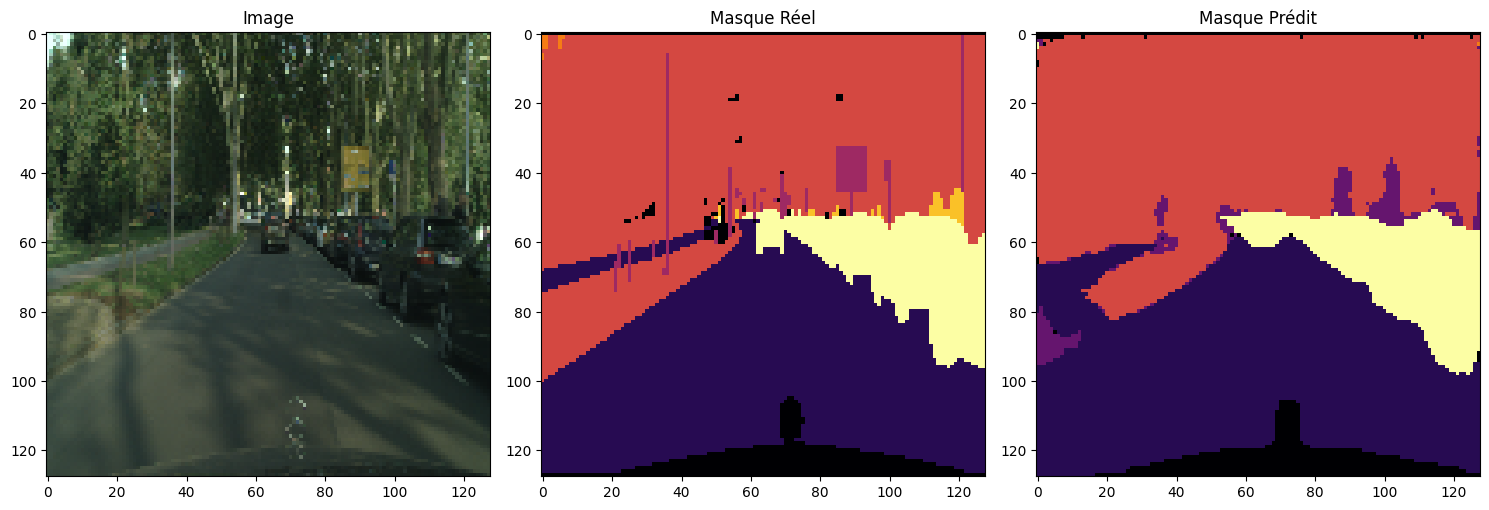

186/186 ━━━━━━━━━━━━━━━━━━━━ 179s 930ms/step - iou_with_conversion: 0.3324 - loss: 0.6804 - val_iou_with_conversion: 0.3669 - val_loss: 0.6046 - learning_rate: 1.0000e-04
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - iou_with_conversion: 0.4092 - loss: 0.5507
Epoch 3: val_loss improved from 0.60462 to 0.53677, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


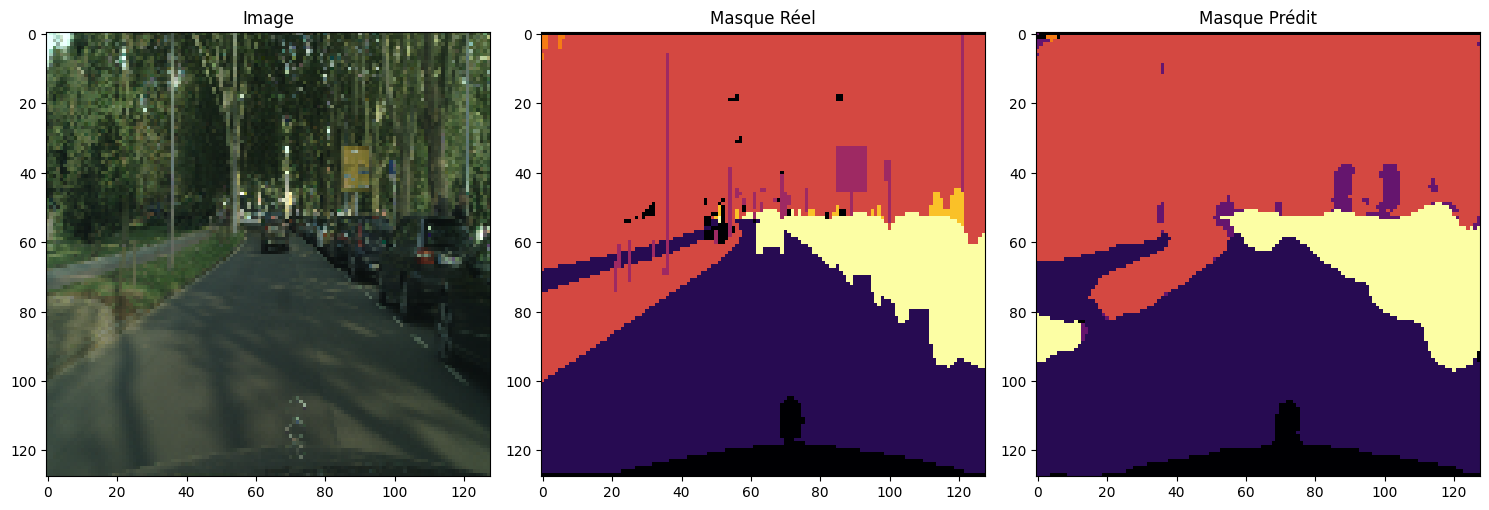

186/186 ━━━━━━━━━━━━━━━━━━━━ 177s 923ms/step - iou_with_conversion: 0.4093 - loss: 0.5506 - val_iou_with_conversion: 0.4313 - val_loss: 0.5368 - learning_rate: 1.0000e-04
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - iou_with_conversion: 0.4492 - loss: 0.4906
Epoch 4: val_loss improved from 0.53677 to 0.51917, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


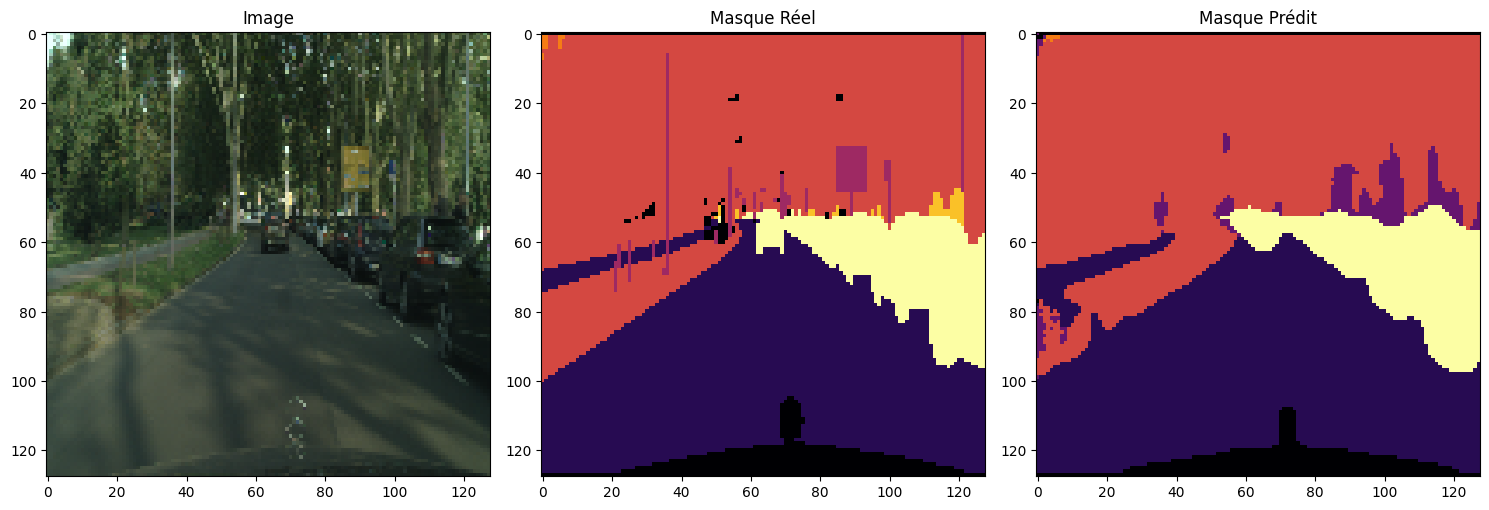

186/186 ━━━━━━━━━━━━━━━━━━━━ 176s 917ms/step - iou_with_conversion: 0.4493 - loss: 0.4906 - val_iou_with_conversion: 0.4355 - val_loss: 0.5192 - learning_rate: 1.0000e-04
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - iou_with_conversion: 0.4706 - loss: 0.4627
Epoch 5: val_loss improved from 0.51917 to 0.47215, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


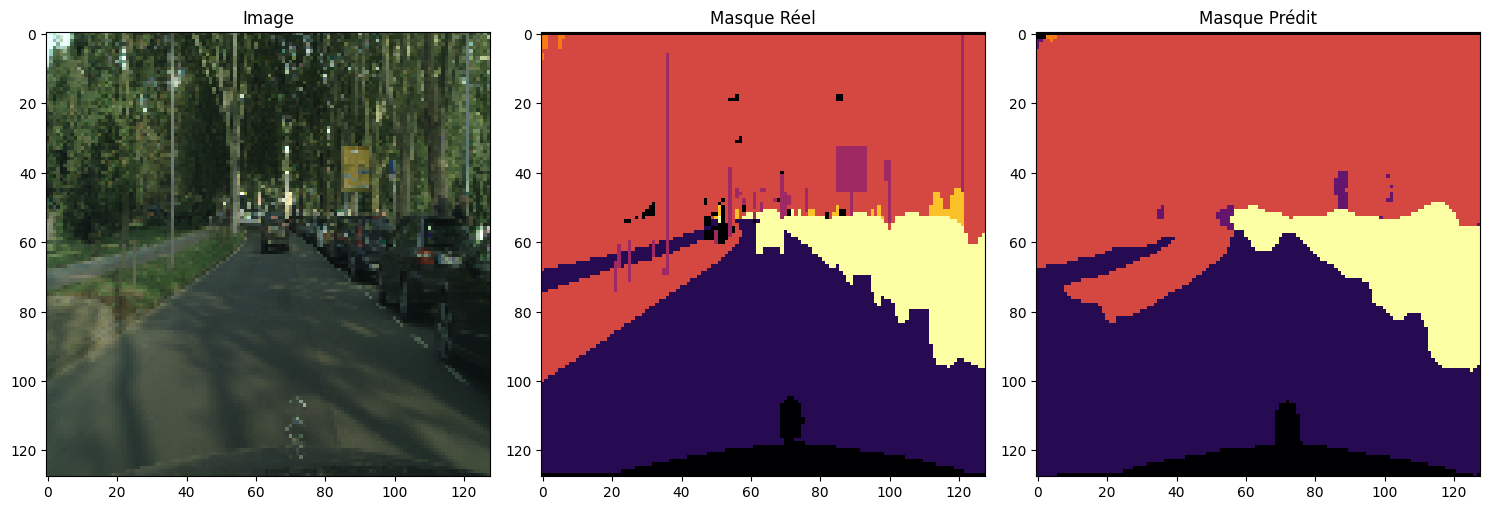

186/186 ━━━━━━━━━━━━━━━━━━━━ 176s 918ms/step - iou_with_conversion: 0.4706 - loss: 0.4627 - val_iou_with_conversion: 0.4794 - val_loss: 0.4722 - learning_rate: 1.0000e-04
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - iou_with_conversion: 0.4865 - loss: 0.4404
Epoch 6: val_loss improved from 0.47215 to 0.44536, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


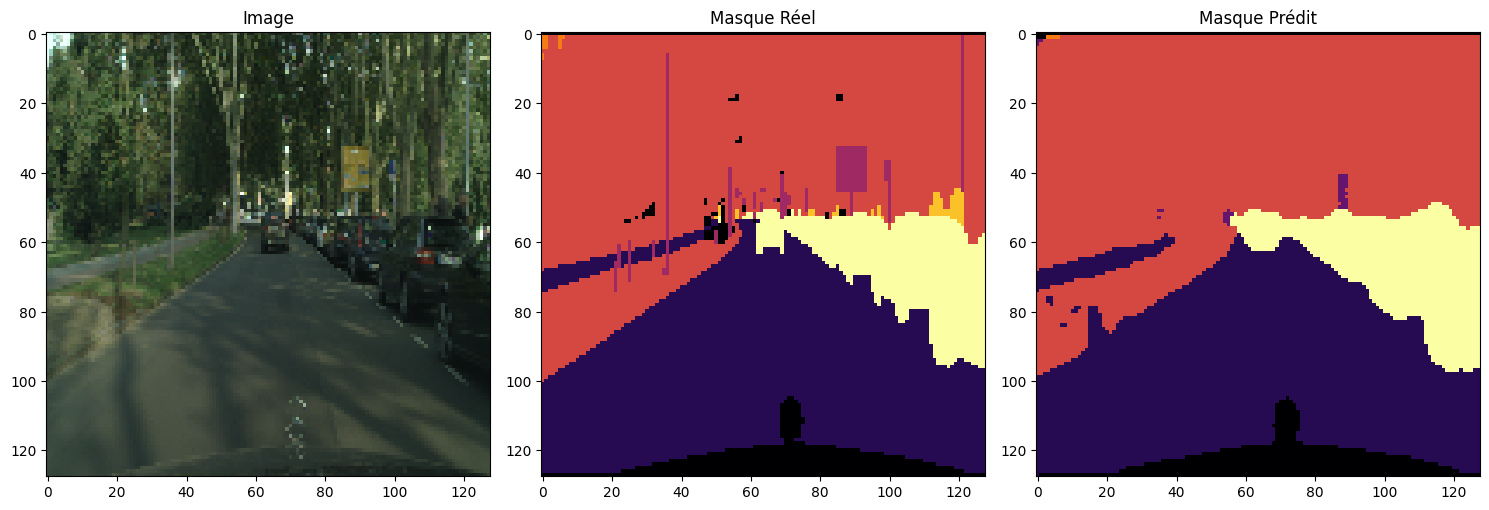

186/186 ━━━━━━━━━━━━━━━━━━━━ 176s 915ms/step - iou_with_conversion: 0.4865 - loss: 0.4404 - val_iou_with_conversion: 0.4891 - val_loss: 0.4454 - learning_rate: 1.0000e-04
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - iou_with_conversion: 0.5039 - loss: 0.4127
Epoch 7: val_loss improved from 0.44536 to 0.43766, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


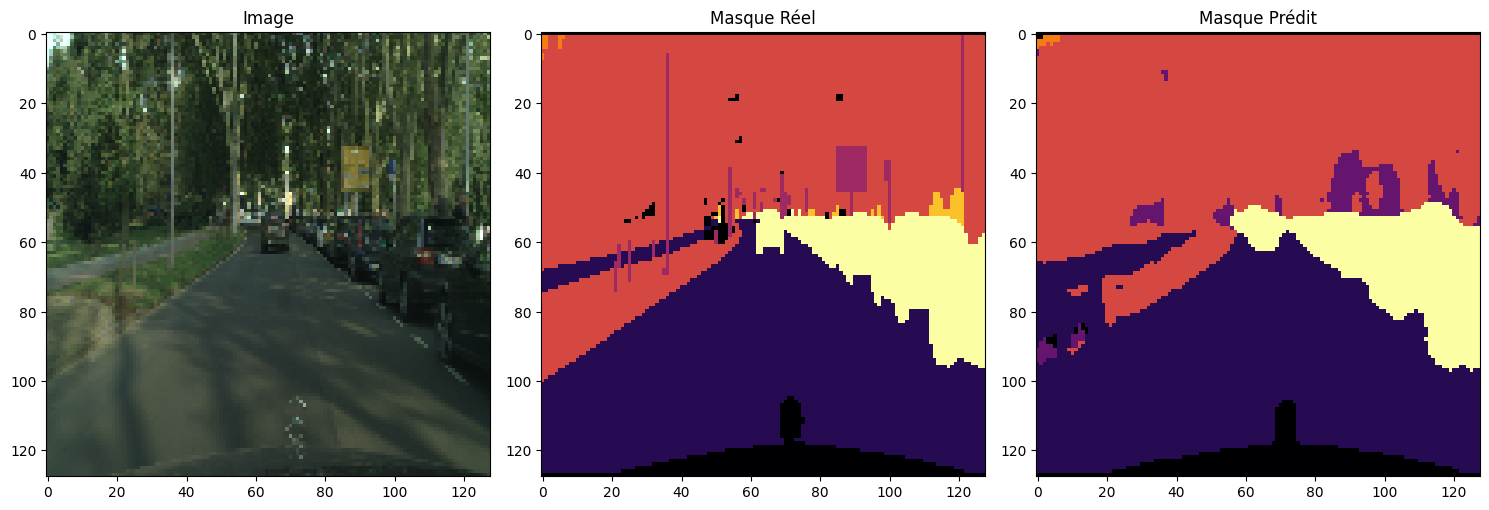

186/186 ━━━━━━━━━━━━━━━━━━━━ 177s 922ms/step - iou_with_conversion: 0.5039 - loss: 0.4127 - val_iou_with_conversion: 0.4987 - val_loss: 0.4377 - learning_rate: 1.0000e-04
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - iou_with_conversion: 0.5112 - loss: 0.4034
Epoch 8: val_loss did not improve from 0.43766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


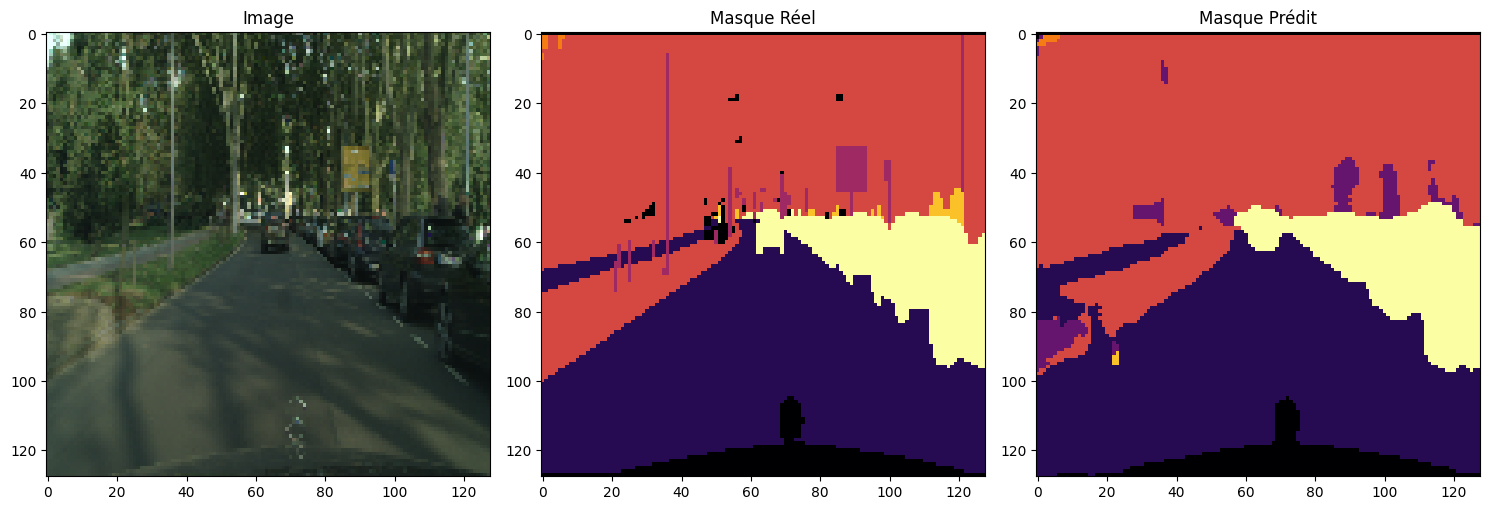

186/186 ━━━━━━━━━━━━━━━━━━━━ 176s 917ms/step - iou_with_conversion: 0.5112 - loss: 0.4034 - val_iou_with_conversion: 0.5047 - val_loss: 0.4887 - learning_rate: 1.0000e-04
Epoch 9/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - iou_with_conversion: 0.5166 - loss: 0.3982
Epoch 9: val_loss improved from 0.43766 to 0.41583, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


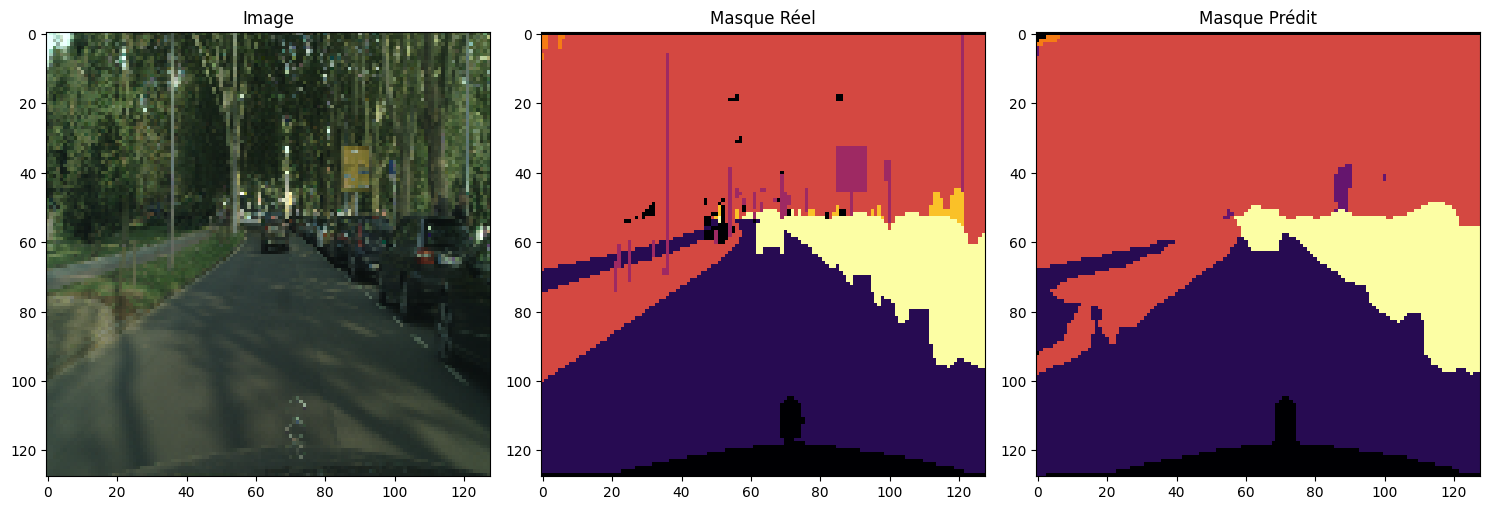

186/186 ━━━━━━━━━━━━━━━━━━━━ 176s 918ms/step - iou_with_conversion: 0.5167 - loss: 0.3982 - val_iou_with_conversion: 0.5180 - val_loss: 0.4158 - learning_rate: 1.0000e-04
Epoch 10/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - iou_with_conversion: 0.5283 - loss: 0.3830
Epoch 10: val_loss did not improve from 0.41583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


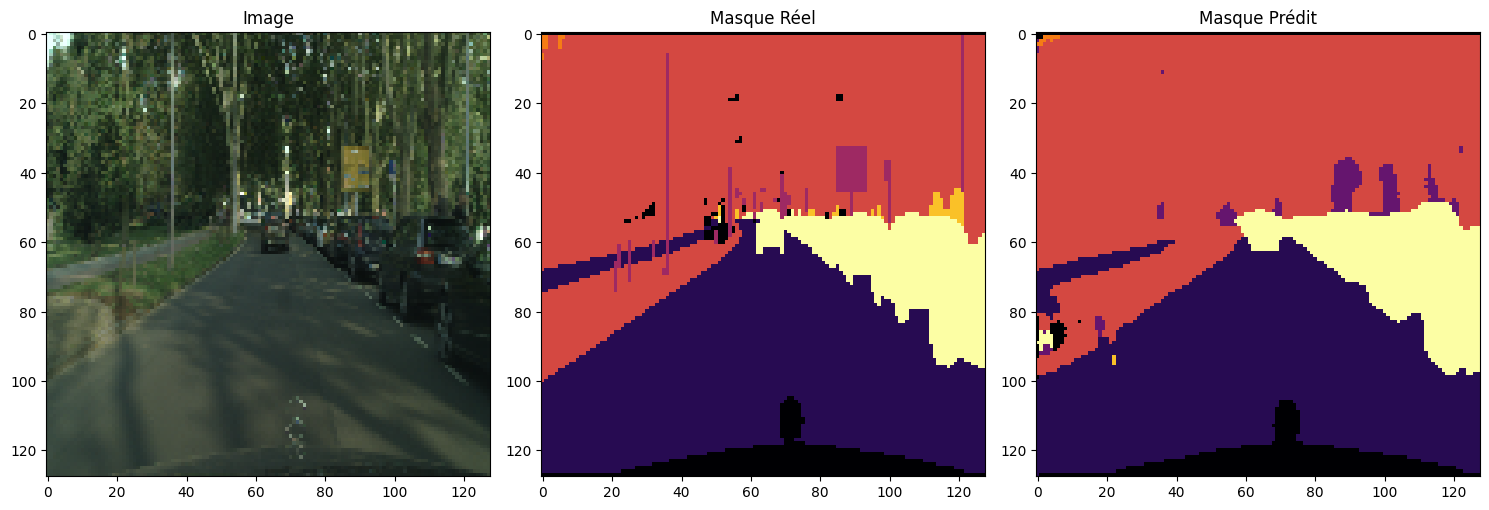

186/186 ━━━━━━━━━━━━━━━━━━━━ 173s 903ms/step - iou_with_conversion: 0.5283 - loss: 0.3830 - val_iou_with_conversion: 0.5399 - val_loss: 0.4181 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 9.

Entraînement terminé.
Les meilleurs poids ont été restaurés.


In [94]:
# Entraînement
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# Résumé final
print("\nEntraînement terminé.")
print("Les meilleurs poids ont été restaurés.")